## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 7
register_matplotlib_converters()

## Dataset

**Data Listrik**

In [ ]:
data_listrik = pd.read_excel('/content/dataset_listrik.xlsx', index_col='Tanggal')
data_listrik.index = pd.to_datetime(data_listrik.index)

data_siang = pd.DataFrame(data_listrik['Malam'])
data_siang = data_siang.values
# data_tensor = torch.FloatTensor(data_siang)
data_siang

array([[ 821.  ],
       [ 854.2 ],
       [ 858.3 ],
       ...,
       [1188.45],
       [1169.65],
       [1230.14]])

In [ ]:
data_listrik.head()

,Siang,Malam
Tanggal,,
2016-01-01,631.1,821.0
2016-01-02,652.4,854.2
2016-01-03,643.7,858.3
2016-01-04,717.7,858.3
2016-01-05,756.0,947.4


## Data Preprocessing

**Normalisasi Data**


In [ ]:
def normData(data):
    data_norm = np.zeros((len(data_siang),len(data_siang[0])))

    #inisialisasi variabel min dan max untuk menyimpan data terkecil dan terbesar
    for i in range(len(data_siang[0])):
        minim = data_siang[0][0]
        maks = data_siang[0][0]

    #proses pengambilan data terbesar dan terkecil
    for j in range(len(data_siang)):
        if maks < data_siang[j][i]:
            maks = data_siang[j][i]
        elif minim > data_siang[j][i]:
            minim = data_siang[j][i]

    #proses normalisasi Min-Max
    for i in range(len(data_siang[0])):
        for j in range(len(data_siang)):
            data_norm[j][i] = (data_siang[j][i]-minim)/(maks-minim)
    print("Minimum: ", minim)
    print("Maksimum: ", maks)
    
    return data_norm, minim, maks 

In [ ]:
data_normalisasi, minim, maks = normData(data_siang)
print(data_normalisasi)

Minimum:  100.8
Maksimum:  1411.2
[[0.54960317]
 [0.57493895]
 [0.57806777]
 ...
 [0.83001374]
 [0.81566697]
 [0.86182845]]


**Transformasi data to sequence**

In [ ]:
def split_sequence(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [ ]:
seq_length = 30
x, y = split_sequence(data_normalisasi, seq_length)
print("X \n",x[:1])
print("Y\n", y[:3])

X 
 [[[0.54960317]
  [0.57493895]
  [0.57806777]
  [0.57806777]
  [0.64606227]
  [0.64781746]
  [0.63827839]
  [0.64629121]
  [0.59691697]
  [0.58501221]
  [0.6122558 ]
  [0.623779  ]
  [0.63049451]
  [0.64094933]
  [0.60492979]
  [0.60492979]
  [0.60950855]
  [0.63888889]
  [0.52760226]
  [0.57486264]
  [0.57348901]
  [0.57087912]
  [0.58852259]
  [0.57989927]
  [0.60782967]
  [0.61072955]
  [0.65804335]
  [0.65460928]
  [0.65285409]
  [0.62232906]]]
Y
 [[0.61729243]
 [0.63270757]
 [0.62912088]]


**divide train & test data**

In [ ]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("dataX: ", dataX.shape)
print("dataY: ", dataY.shape)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)


print("testX: ", testX.shape)
print("testY: ", testY.shape)



dataX:  torch.Size([1467, 30, 1])
dataY:  torch.Size([1467, 1])
trainX:  torch.Size([1173, 30, 1])
trainY:  torch.Size([1173, 1])
testX:  torch.Size([294, 30, 1])
testY:  torch.Size([294, 1])


## Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

# Denormalisasi

In [ ]:
def denormPrediksi(targetPrediksi, minim, maks):
  denormPrediksi = np.zeros((len(targetPrediksi), len(targetPrediksi[0])))
  for i in range(len(targetPrediksi)):
    for j in range(len(targetPrediksi[i])):
      denormPrediksi[i][j] = (targetPrediksi[i][j] * (maks - minim)) + minim
  
  return denormPrediksi

# Hitung RMSE hasil prediksi

In [ ]:
def count_rmse(data_prediksi, data_aktual):
  error = []
  for i in range(len(data_prediksi)):
    err_i = (data_aktual[i] - data_prediksi[i])**2
    error.append(err_i)
    # print(data_aktual[i], data_prediksi[i], err_i)

  mse = sum(error)/len(data_prediksi)
  rmse = np.sqrt(mse)

  return mse, rmse

# Start Train dan Test

Epoch 0 train loss: 0.2821269929409027 test loss: 0.5161487460136414
Epoch 500 train loss: 0.0030096250120550394 test loss: 0.03124430775642395
Epoch 1000 train loss: 0.0017615040997043252 test loss: 0.0035530191380530596
Epoch 1500 train loss: 0.0016320286085829139 test loss: 0.0024485422763973475
Epoch 2000 train loss: 0.0015551761025562882 test loss: 0.0020657835993915796
Epoch 2500 train loss: 0.0015121980104595423 test loss: 0.0018300225492566824
Epoch 3000 train loss: 0.0014770649140700698 test loss: 0.0016534279566258192

LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
30


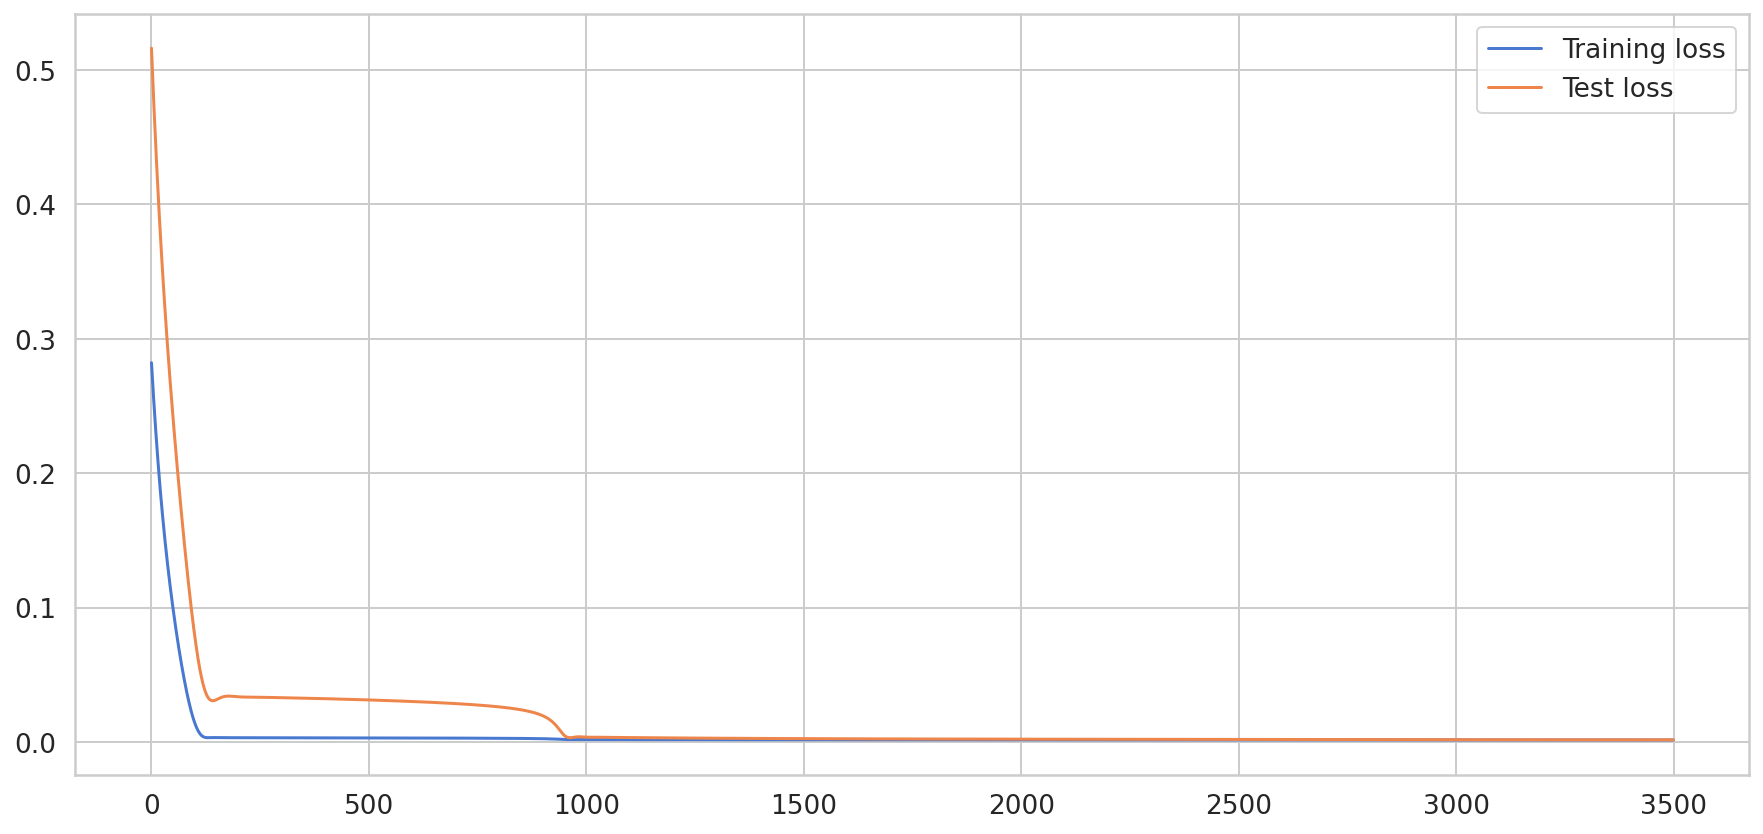

In [ ]:
num_epochs = 3500
learning_rate = 0.001

input_size = 1
hidden_size = 8
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    # backprop
    loss.backward()
    # update bobot
    optimizer.step()

    with torch.no_grad():
      y_test_pred = lstm(testX)
      # y_hasil_test.append(y_test_pred)
      test_loss = criterion(y_test_pred.float(), testY)
      test_hist[epoch] = test_loss.item()

    
    train_hist[epoch] = loss.item()
    if epoch % 500 == 0:
      # print("Epoch: %d, train loss: %1.5f" % (epoch, loss.item()))
      print(f'Epoch {epoch} train loss: {loss.item()} test loss: {test_loss.item()}')
print()
print(lstm.eval())
print(seq_length)
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

# Testing All Data

---




LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
30

ALL DATA SET
MSE  :  [2514.91615514]
RMSE :  [50.14893972]


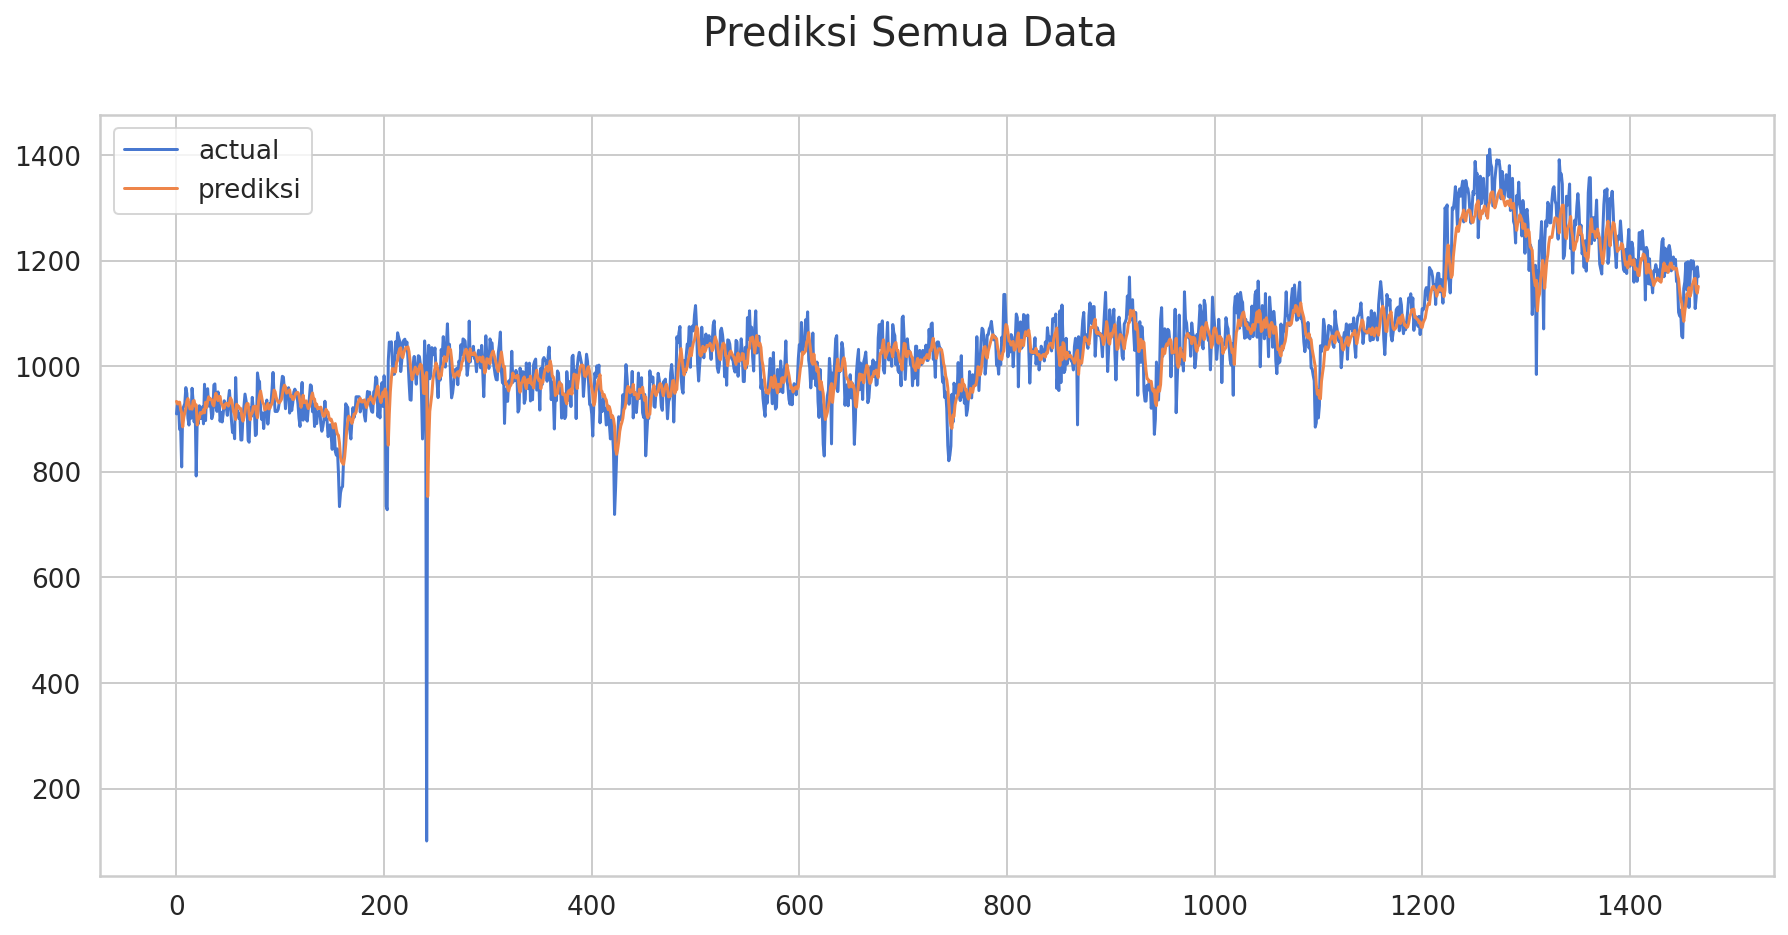

In [ ]:
lstm.eval()
# test all data
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# denormalisasi
data_predict = denormPrediksi(data_predict,  minim, maks)
dataY_plot = denormPrediksi(dataY_plot,  minim, maks)

print()
print(lstm.eval())
print(seq_length)
print()

mse, rmse = count_rmse(data_predict, dataY_plot)
print("ALL DATA SET")
print("MSE  : ",mse)
print("RMSE : ", rmse)

# plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label= 'actual')
plt.plot(data_predict, label='prediksi')
plt.suptitle('Prediksi Semua Data', fontsize=20)
plt.legend()
plt.show()

# Testing Data Test


TEST DATA ONLY
MSE  :  [2696.56780712]
RMSE :  [51.92848743]

LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)



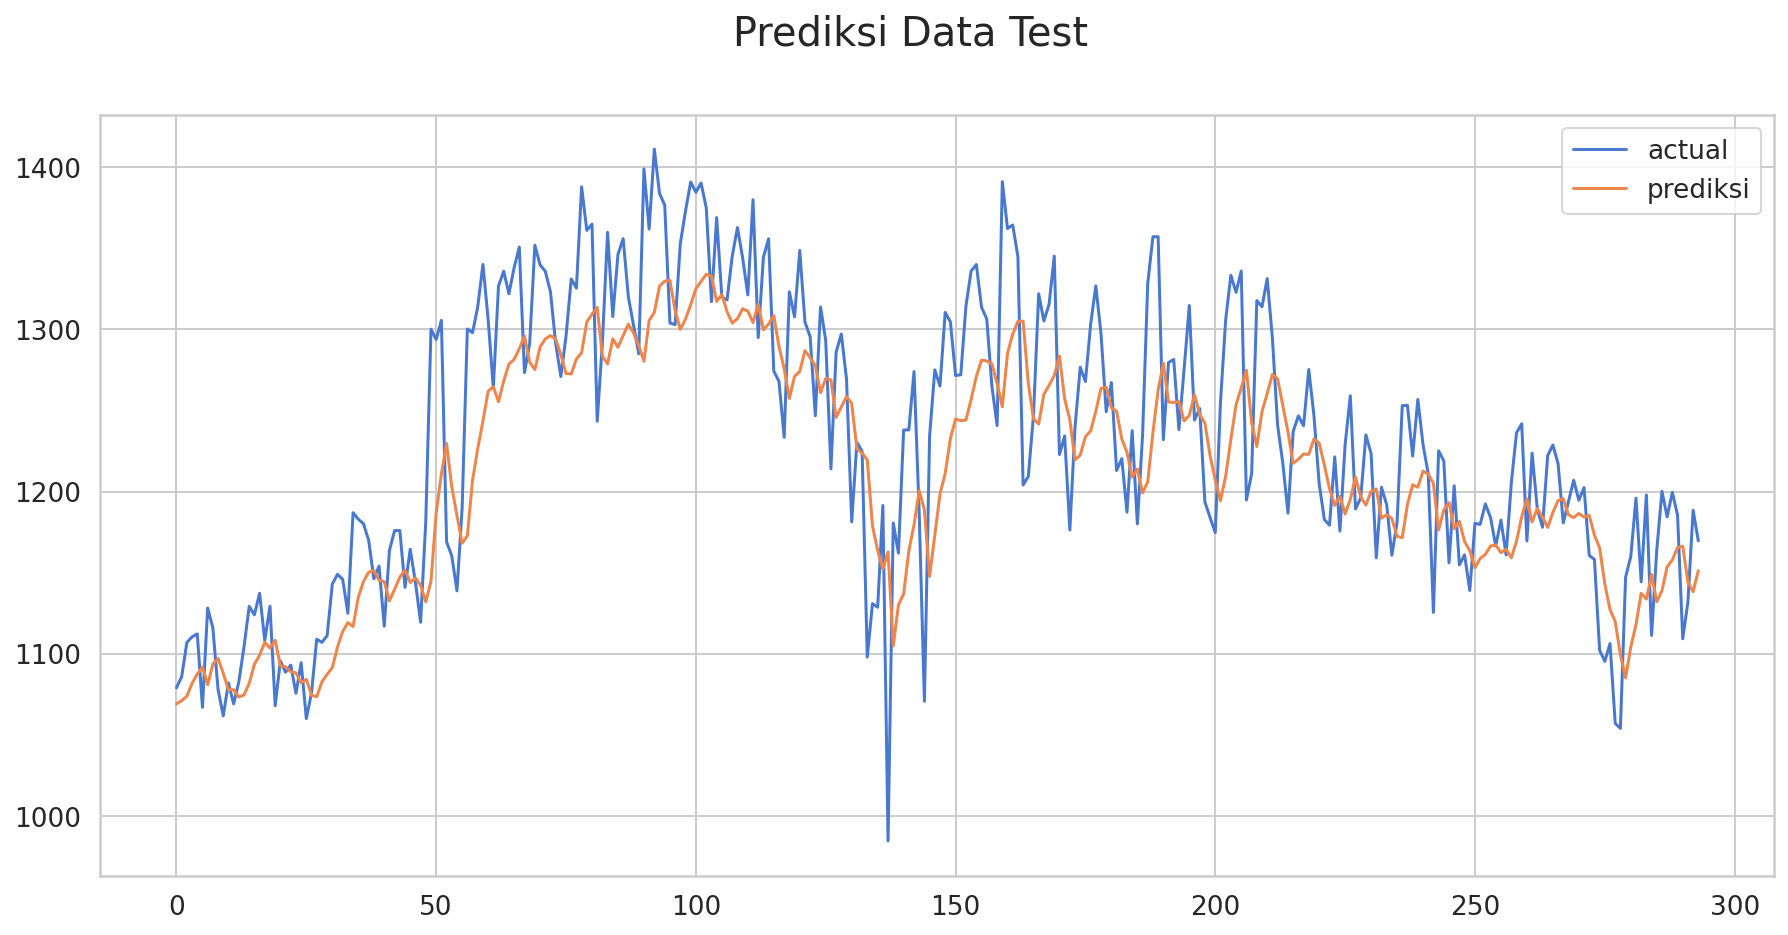

In [ ]:
# testing system
# testing test data
train_predict = lstm(testX)

# convert to numpy
data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

# denormalisasi
data_predict = denormPrediksi(data_predict,  minim, maks)
dataY_actual = denormPrediksi(dataY_plot,  minim, maks)

# count MSE
mse, rmse = count_rmse(data_predict, dataY_actual)
print("TEST DATA ONLY")
print("MSE  : ",mse)
print("RMSE : ", rmse)
print()

print(lstm.eval())
print()

plt.plot(dataY_actual, label= 'actual')
plt.plot(data_predict, label='prediksi')
plt.suptitle('Prediksi Data Test', fontsize=20)
plt.legend()
plt.show()

# Multi layer

In [ ]:
class LSTM_multi(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_multi, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        # final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        ul_a, (h_outt, c_outt) = self.lstm(x, (h_1, c_1))
        
        h_outt = h_outt.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        
        out = self.fc(h_outt)
        
        return out

In [ ]:
# multi layer
num_epochs = 2500
learning_rate = 0.001

input_size = 1
hidden_size = 64
num_layers = 2

num_classes = 1

lstm_multi = LSTM_multi(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_multi.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)

# Train the model
for epoch in range(num_epochs):
  outputs = lstm_multi(trainX)
  optimizer.zero_grad()
  
  # obtain the loss function
  loss = criterion(outputs, trainY)
  #  backprop
  loss.backward()
  # update bobot
  optimizer.step()

  with torch.no_grad():
    y_test_pred = lstm_multi(testX)
    # y_hasil_test.append(y_test_pred)
    test_loss = criterion(y_test_pred.float(), testY)
    test_hist[epoch] = test_loss.item()

    
  train_hist[epoch] = loss.item()
  if epoch % 100 == 0:
  # print("Epoch: %d, train loss: %1.5f" % (epoch, loss.item()))
    print(f'Epoch {epoch} train loss: {loss.item()} test loss: {test_loss.item()}')
print()
print(lstm_multi.eval())
print(seq_length)

Epoch 0 train loss: 0.36478954553604126 test loss: 0.5250287652015686
Epoch 100 train loss: 0.0026940573006868362 test loss: 0.02158481627702713
Epoch 200 train loss: 0.0025894916616380215 test loss: 0.019292229786515236
Epoch 300 train loss: 0.002420959295704961 test loss: 0.016235731542110443
Epoch 400 train loss: 0.0018306554993614554 test loss: 0.00222929660230875
Epoch 500 train loss: 0.0017824905226007104 test loss: 0.0022664873395115137
Epoch 600 train loss: 0.001758025144226849 test loss: 0.0024738372303545475
Epoch 700 train loss: 0.001735537895001471 test loss: 0.002524336101487279
Epoch 800 train loss: 0.0017150960629805923 test loss: 0.002417628187686205
Epoch 900 train loss: 0.001696535386145115 test loss: 0.002219363348558545
Epoch 1000 train loss: 0.0016795252449810505 test loss: 0.0019878726452589035
Epoch 1100 train loss: 0.0016635280335322022 test loss: 0.0017330585978925228
Epoch 1200 train loss: 0.0016471205744892359 test loss: 0.001446245238184929
Epoch 1300 train 

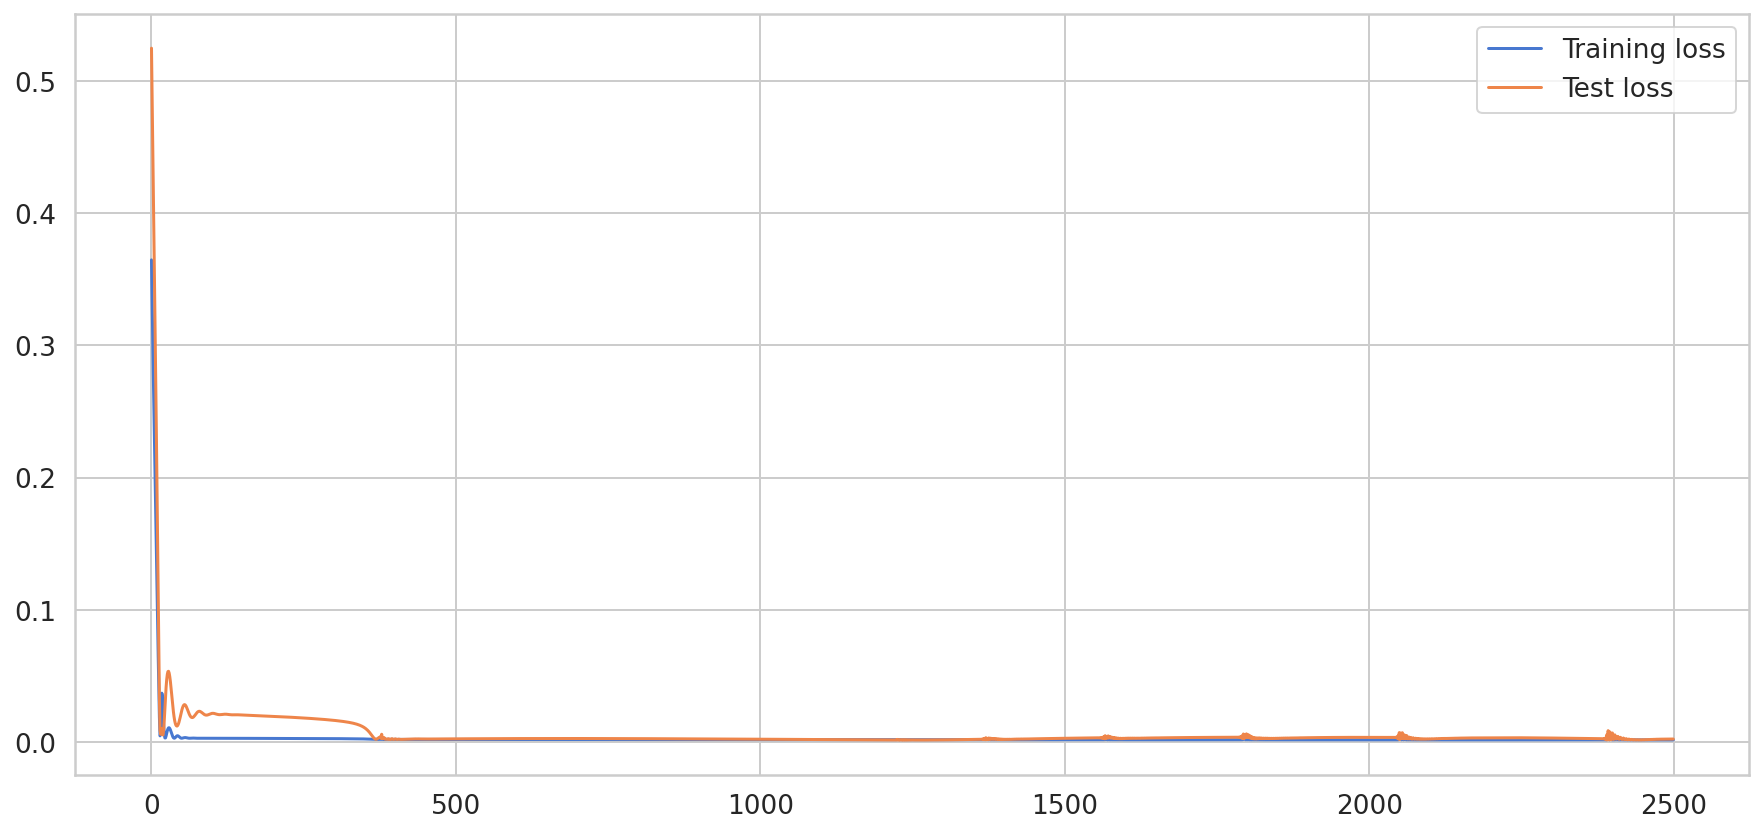

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [ ]:
# testing system
# testing test data
train_predict = lstm_multi(testX)

# convert to numpy
data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

# denormalisasi
data_predict = denormPrediksi(data_predict,  minim, maks)
dataY_actual = denormPrediksi(dataY_plot,  minim, maks)

# count MSE
mse, rmse = count_mse(data_predict, dataY_actual)
print("TEST DATA ONLY")
print("MSE  : ",mse)
print("RMSE : ", rmse)

TEST DATA ONLY
MSE  :  [3666.40073742]
RMSE :  [60.5508112]


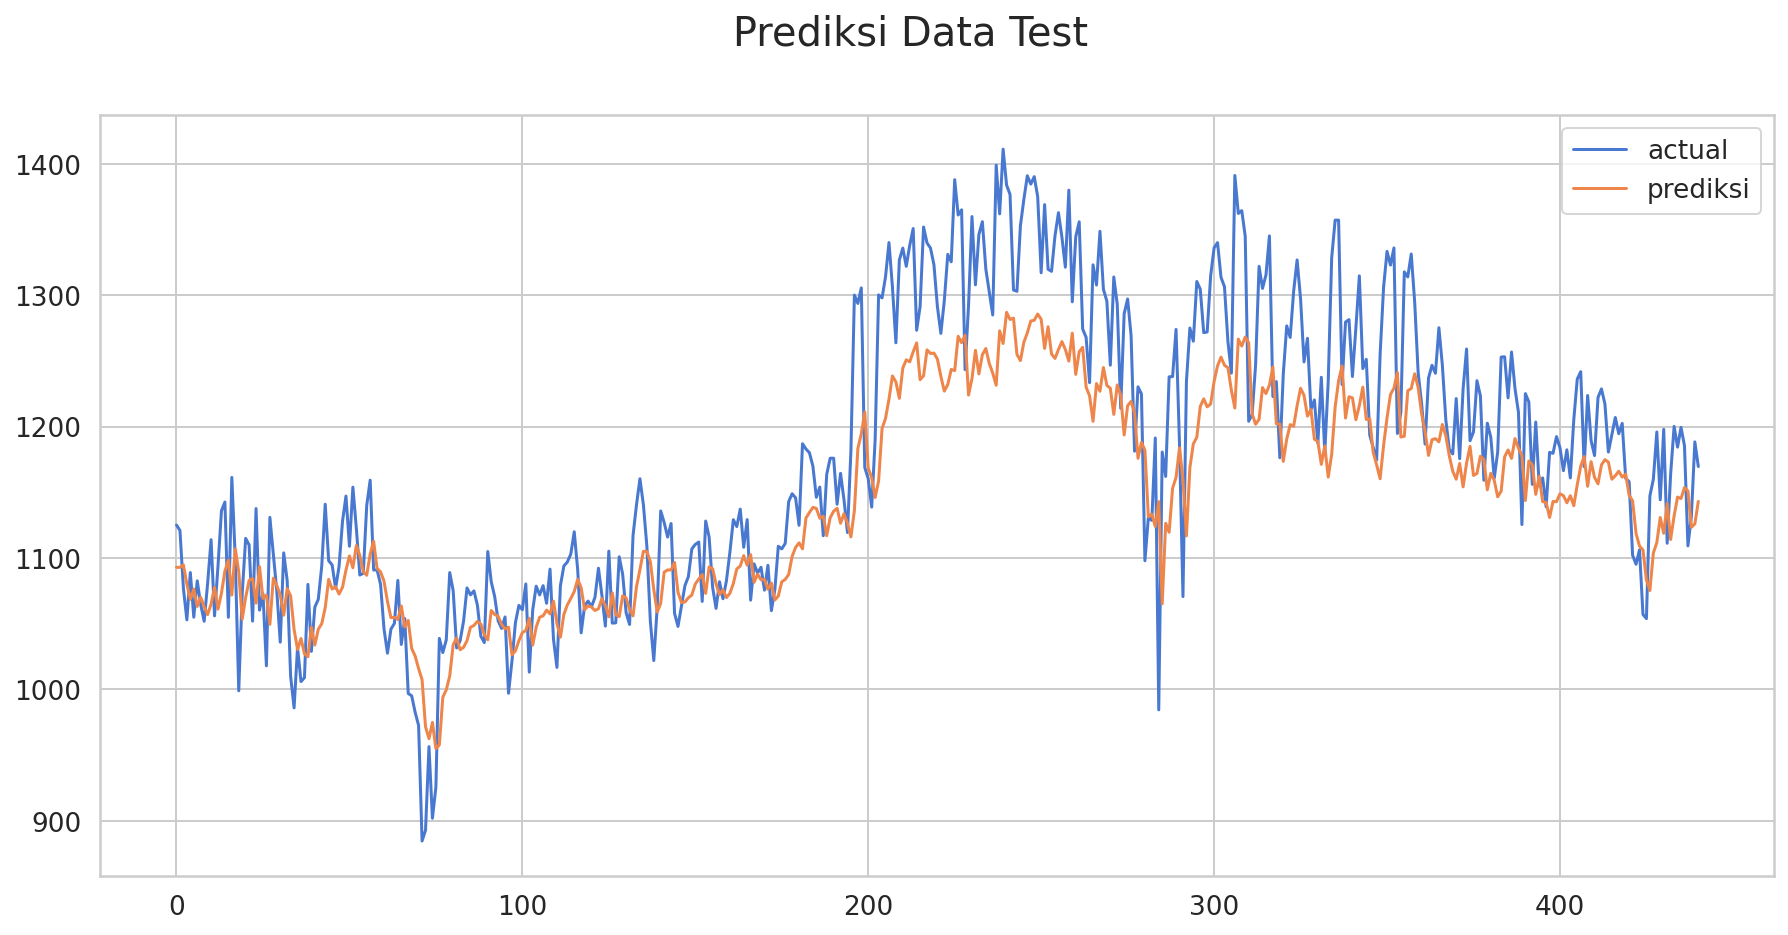

In [ ]:
plt.plot(dataY_actual, label= 'actual')
plt.plot(data_predict, label='prediksi')
plt.suptitle('Prediksi Data Test', fontsize=20)
plt.legend()
plt.show()

# New Section

In [ ]:
#  Print model's state_dict
print("Model's state_dict:")
for param_tensor in lstm.state_dict():
    print(param_tensor, "\t", lstm.state_dict()[param_tensor].size())

Model's state_dict:
lstm.weight_ih_l0 	 torch.Size([256, 1])
lstm.weight_hh_l0 	 torch.Size([256, 64])
lstm.bias_ih_l0 	 torch.Size([256])
lstm.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 64])
fc.bias 	 torch.Size([1])
